In [2]:
# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd
import warnings

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv(f'../GeneratedData/3secondsData/combined_audio_features_dataset.csv')
data = data.iloc[0:, 1:] 
data.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,filename,Genre,TrackID,label
0,0.373450,0.080916,0.174810,0.000541,3162.449198,329533.774091,2627.407208,81816.391568,6130.006010,1.046002e+06,...,6.509262,50.696000,7.223249,66.506355,4.121788,16.764467,Metal-TRFOBPI128F42734B9-9,Metal,TRFOBPI128F42734B9,Metal
1,0.398042,0.078598,0.182246,0.000356,3087.525456,43535.906874,2381.175347,22401.526132,5587.120831,2.245332e+05,...,0.311135,28.073776,0.827938,39.998615,-4.096991,29.780815,Metal-TRNNKWM128F934AB1B-4,Metal,TRNNKWM128F934AB1B,Metal
2,0.568134,0.051796,0.231052,0.000754,2930.931204,69212.809501,2649.551889,28052.901189,6145.079252,3.093470e+05,...,3.073705,15.213191,-1.099274,18.522097,-0.074049,23.452896,Metal-TRLMMQH128F934B56B-2,Metal,TRLMMQH128F934B56B,Metal
3,0.441777,0.078464,0.132867,0.000199,2230.312675,57252.479917,2177.495649,25176.065589,4485.531851,1.195460e+05,...,-4.048587,18.734037,0.800622,20.265940,-2.646929,23.170158,Metal-TRSCACG12903CF0E7B-4,Metal,TRSCACG12903CF0E7B,Metal
4,0.429060,0.087661,0.088123,0.000965,2278.009335,191900.677544,2581.541650,67083.548026,5039.432091,6.708965e+05,...,-2.904819,27.108795,-0.241487,25.838740,-0.652817,16.830242,Metal-TRFQYPZ12903CF0E76-10,Metal,TRFQYPZ12903CF0E76,Metal


In [4]:
y = data['label'] # genre variable.
X = data.drop(columns=['label','TrackID','Genre','filename']) #select all columns but not the labels

#### NORMALIZE X ####

# Normalize so everything is on the same scale. 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

30% Testing Data, 70% Training Data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
# Accuracy of models

def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_assess(nn, "Neural Nets")

Accuracy Naive Bayes : 0.20384 

Accuracy Stochastic Gradient Descent : 0.2145 

Accuracy KNN : 0.60698 

Accuracy Decission trees : 0.34666 

Accuracy Random Forest : 0.47509 

Accuracy Support Vector Machine : 0.31841 

Accuracy Logistic Regression : 0.30163 

Accuracy Neural Nets : 0.24487 



In [7]:
# Testing more models

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Fit and transform y_train and y_test
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

def model_assess_encoded(model, X_train, y_train, X_test, y_test, title="Default"):
    # Train model with encoded labels
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds_decoded = le.inverse_transform(preds)
    print(f"{title} - Accuracy:", round(accuracy_score(y_test, preds), 5))

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess_encoded(xgb, X_train, y_train_encoded, X_test, y_test_encoded, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess_encoded(xgbrf, X_train, y_train_encoded, X_test, y_test_encoded, "Cross Gradient Booster (Random Forest)")

Cross Gradient Booster - Accuracy: 0.69544
Cross Gradient Booster (Random Forest) - Accuracy: 0.41727


In [10]:
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label encoding mapping:")
print(label_mapping)

Label encoding mapping:
{'Blues': 0, 'Country': 1, 'Electronic': 2, 'Folk': 3, 'Jazz': 4, 'Latin': 5, 'Metal': 6, 'New Age': 7, 'Pop': 8, 'Punk': 9, 'Rap': 10, 'Reggae': 11, 'RnB': 12, 'Rock': 13, 'World': 14}


Accuracy : 0.69544 



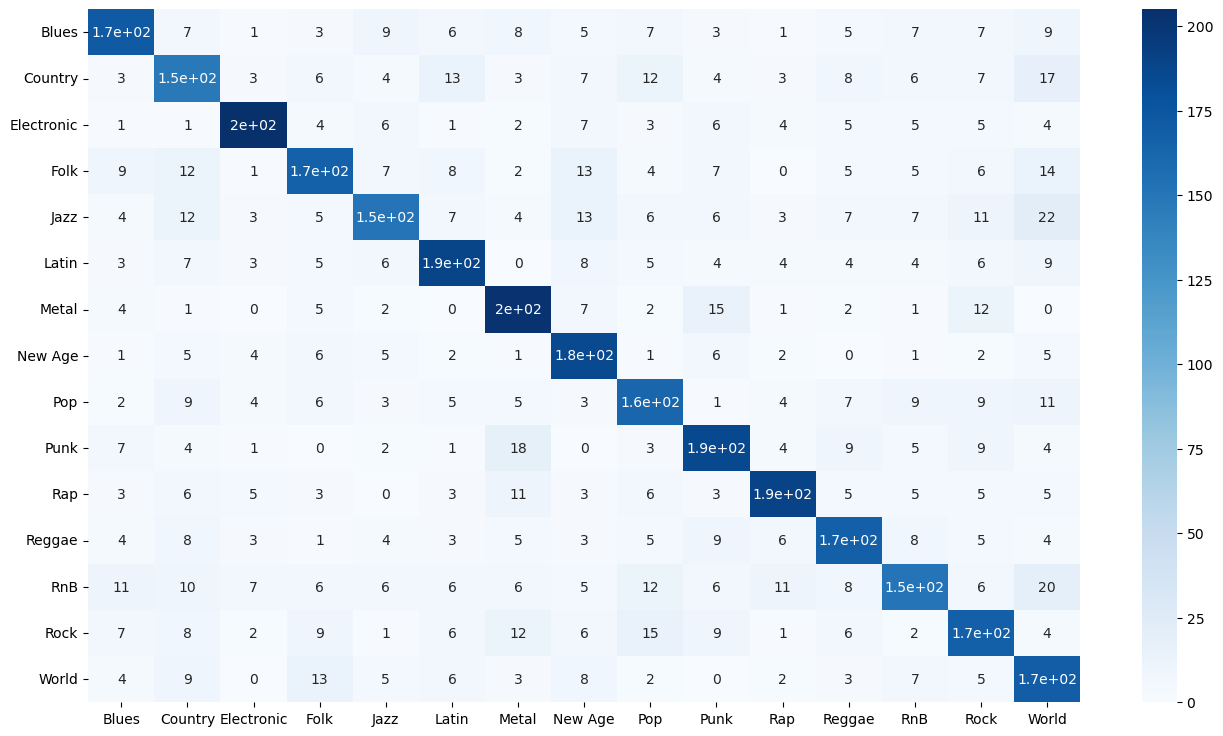

In [12]:
# Final model, XGB had best accuracy
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
xgb.fit(X_train, y_train_encoded)

preds = xgb.predict(X_test)

print('Accuracy', ':', round(accuracy_score(y_test_encoded, preds), 5), '\n')

# Confusion Matrix
confusion_matr = confusion_matrix(y_test_encoded, preds) #normalize = 'true'
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True,
            xticklabels=['Blues', 'Country', 'Electronic', 'Folk', 'Jazz', 'Latin', 'Metal', 'New Age', 'Pop', 'Punk', 'Rap', 'Reggae', 'RnB', 'Rock', 'World'],
            yticklabels=['Blues', 'Country', 'Electronic', 'Folk', 'Jazz', 'Latin', 'Metal', 'New Age', 'Pop', 'Punk', 'Rap', 'Reggae', 'RnB', 'Rock', 'World']) 
plt.savefig("conf matrix")
plt.show()

In [9]:
print(y_train.unique())


['Latin' 'RnB' 'New Age' 'Rap' 'Blues' 'Rock' 'Folk' 'World' 'Punk'
 'Electronic' 'Reggae' 'Country' 'Metal' 'Pop' 'Jazz']
